In [4]:
import xarray as xr
import numpy as np
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures

In [7]:
da = xr.open_dataarray('/home/lalandmi/data/esacci/nhsce_v01r01_1982-2020_5km.nc')
da

<xarray.DataArray 'snow_cover_extent' (time: 2023, lat: 600, lon: 1000)>
[1213800000 values with dtype=float64]
Coordinates:
  * time                  (time) datetime64[ns] 1982-01-04 ... 2020-10-05
    snow_cover_threshold  float32 ...
  * lon                   (lon) float64 60.03 60.08 60.12 ... 109.9 109.9 110.0
  * lat                   (lat) float64 20.02 20.08 20.12 ... 49.88 49.92 49.97
Attributes:
    regrid_method:  bilinear

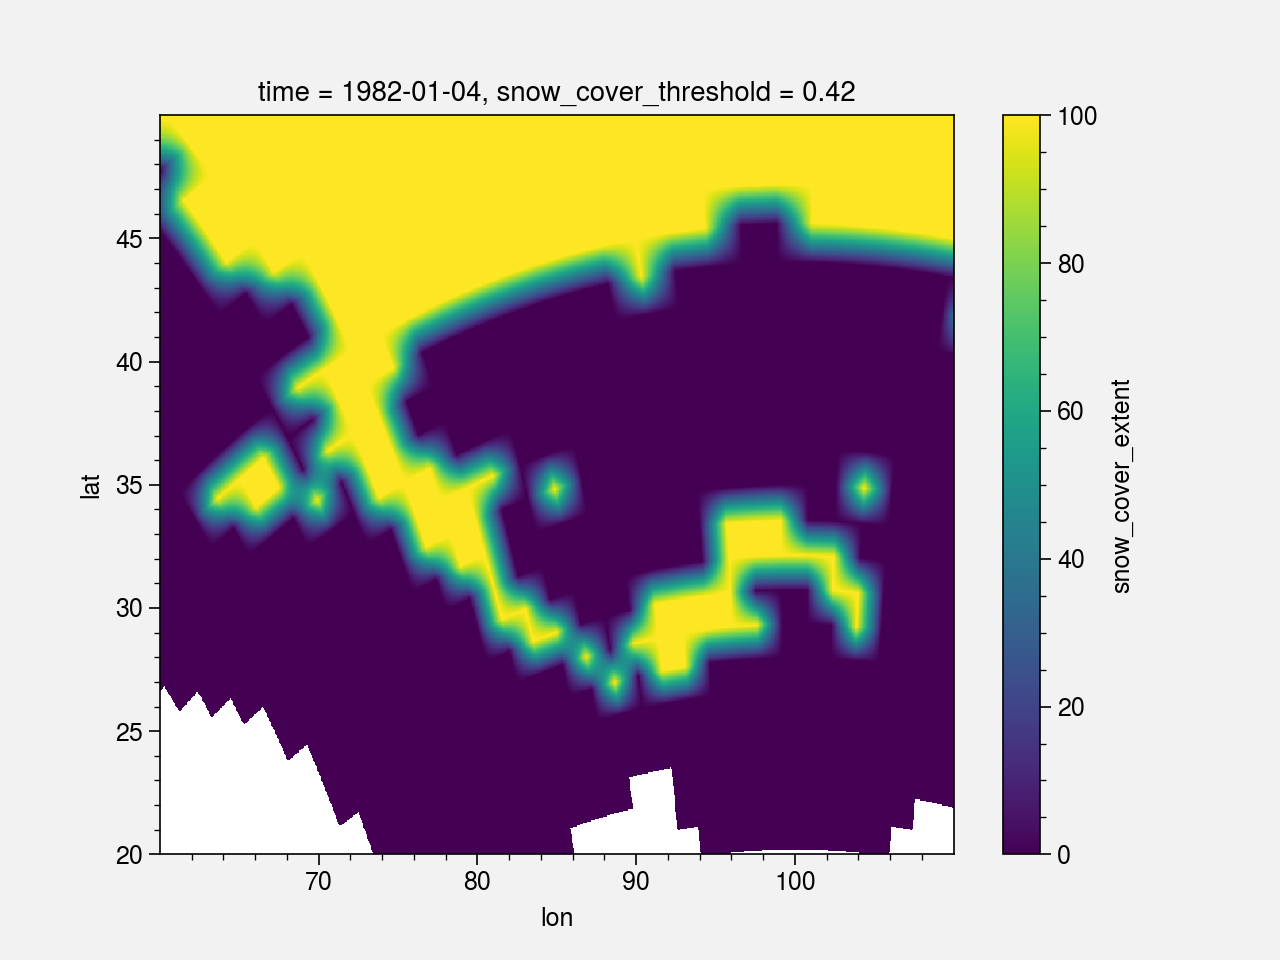

In [9]:
da[0].plot()

In [10]:
mon_da = da.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)
mon_da

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


<xarray.DataArray 'snow_cover_extent' (time: 466, lat: 600, lon: 1000)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [ 99.98362442,  99.93351717,  99.89336225, ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        ,  99.98188932, ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
...
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.13004223,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
  * time                  (time) datetime64[ns] 1982-01-01 ... 2020-10-01
    snow_cover_threshold  float32 0.42
  * lon                   (lon) float64 60.03 60.08 60.12 ... 109.9 109.9 110.0
  * lat                   (lat) float64 20.02 20.08 20.12 ... 49.88 49.92 49.97
Attributes:
    regrid_method:  bilinear

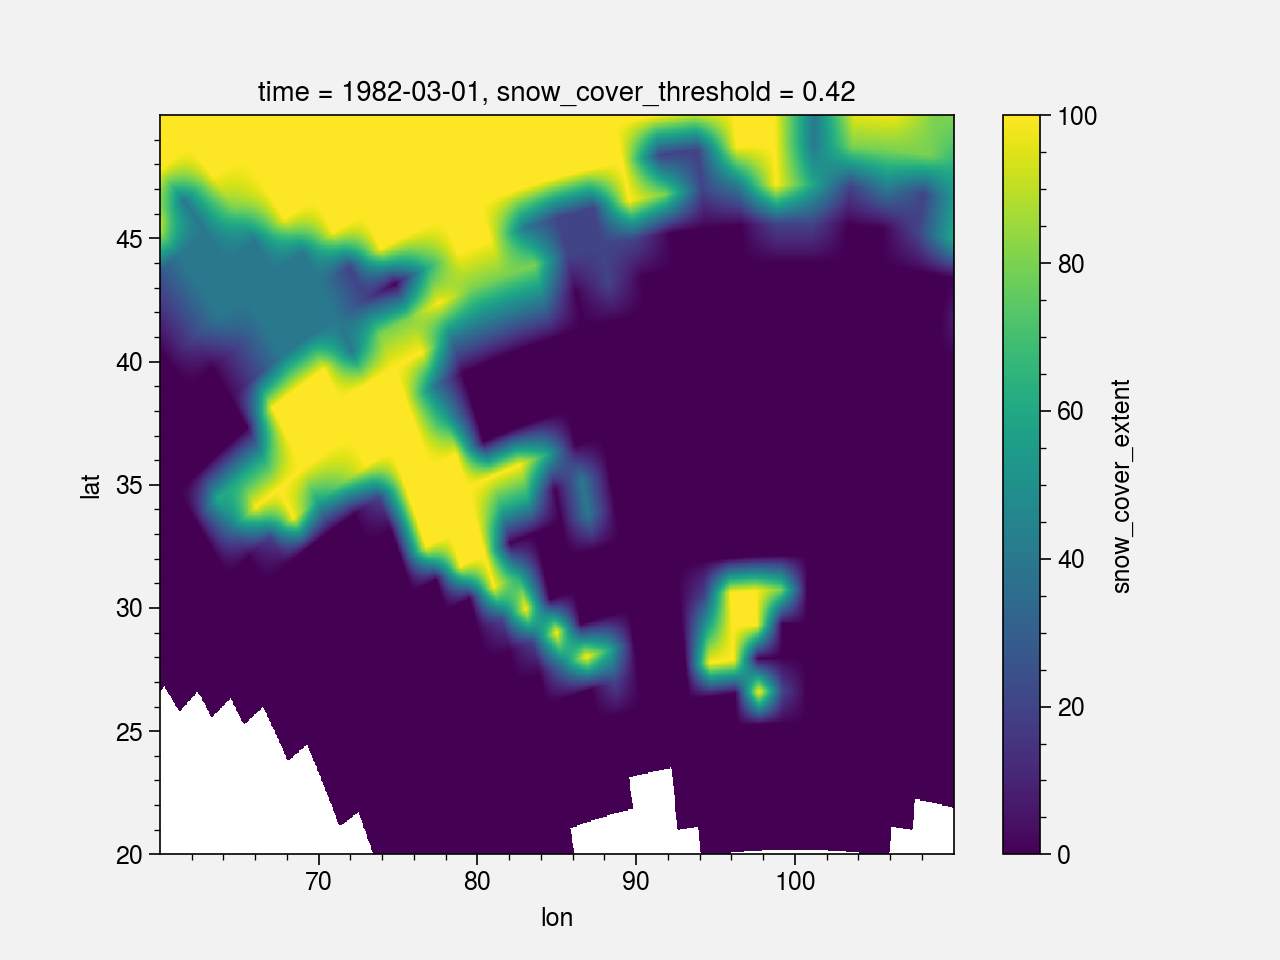

In [14]:
mon_da[2].plot()

In [18]:
ds = xr.open_dataset('data/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=slice(20,50), lon=slice(60,110))
topo = ds.elevation

In [20]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(topo, da, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
topo_regrid = regridder(topo)

Reuse existing file: bilinear_480x800_600x1000.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [24]:
test = mon_da[0]

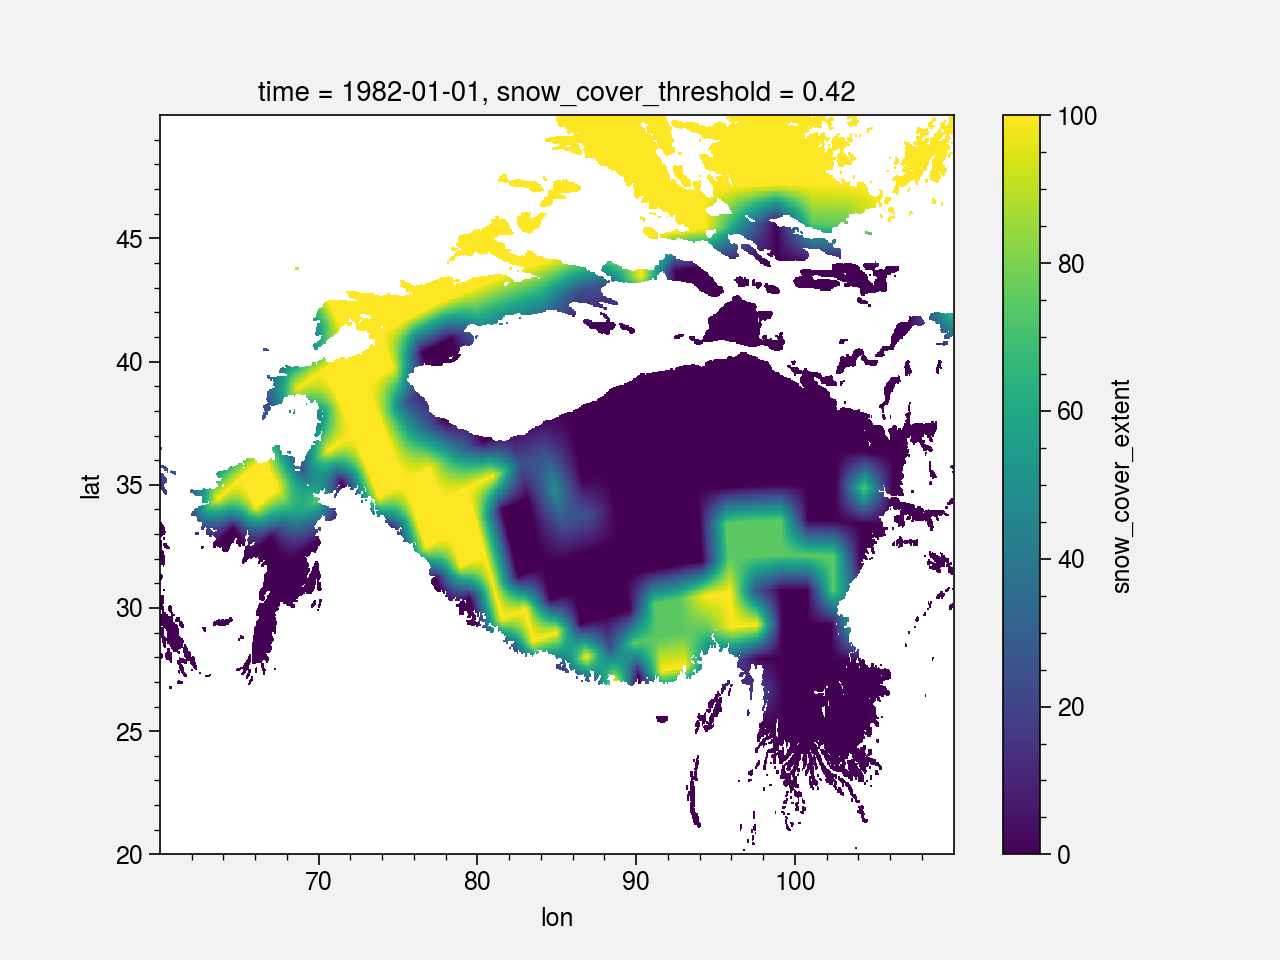

In [26]:
test.where(topo_regrid > 1500).plot()

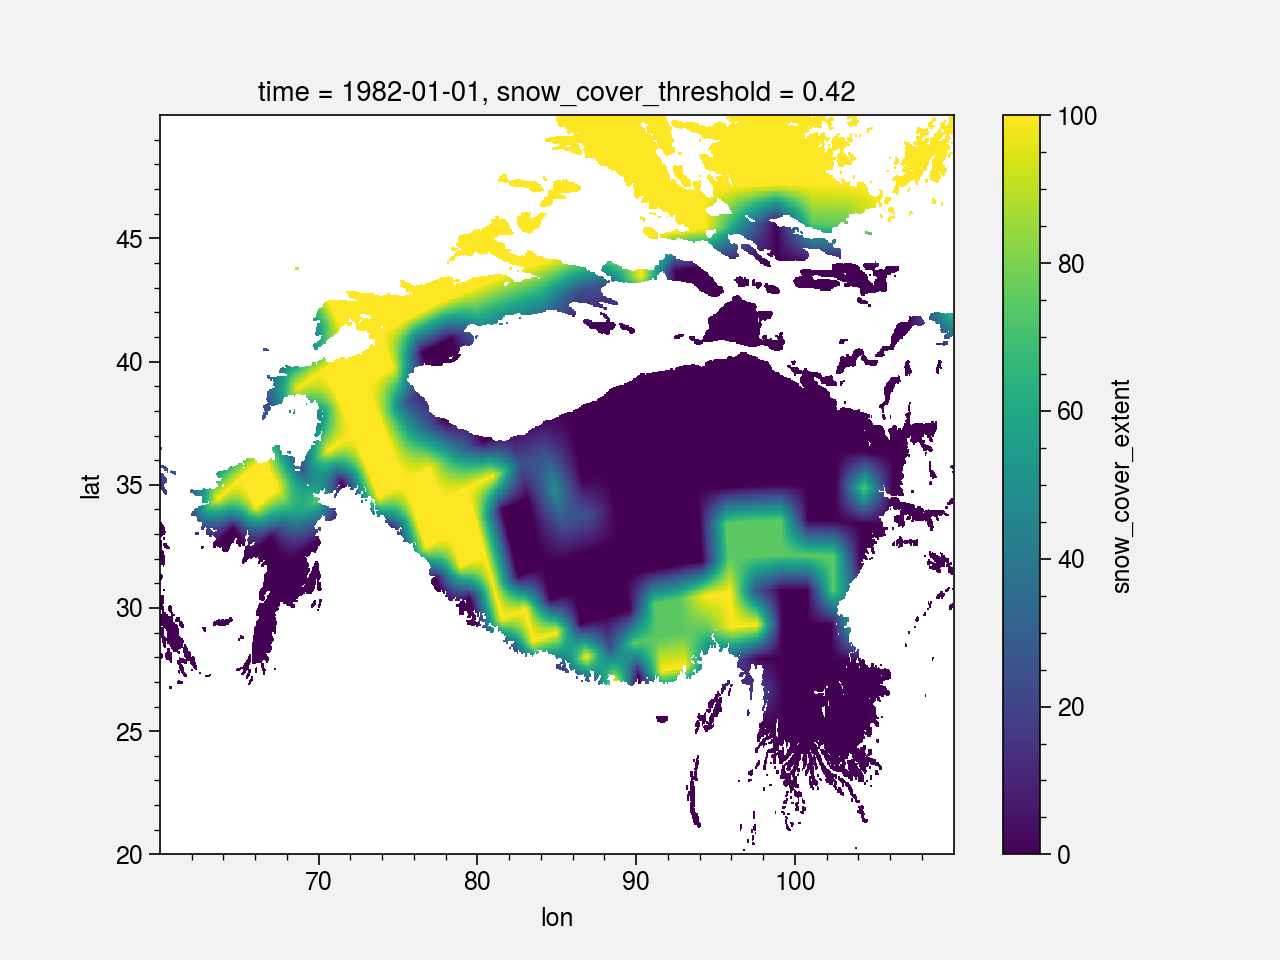

In [27]:
test.where((topo_regrid > 1500)).plot()

In [31]:
test.count()

<xarray.DataArray 'snow_cover_extent' ()>
array(565661)
Coordinates:
    time                  datetime64[ns] 1982-01-01
    snow_cover_threshold  float32 0.42

In [30]:
test.where((topo_regrid > 1500)).count()

<xarray.DataArray 'snow_cover_extent' ()>
array(218512)
Coordinates:
    time                  datetime64[ns] 1982-01-01
    snow_cover_threshold  float32 0.42

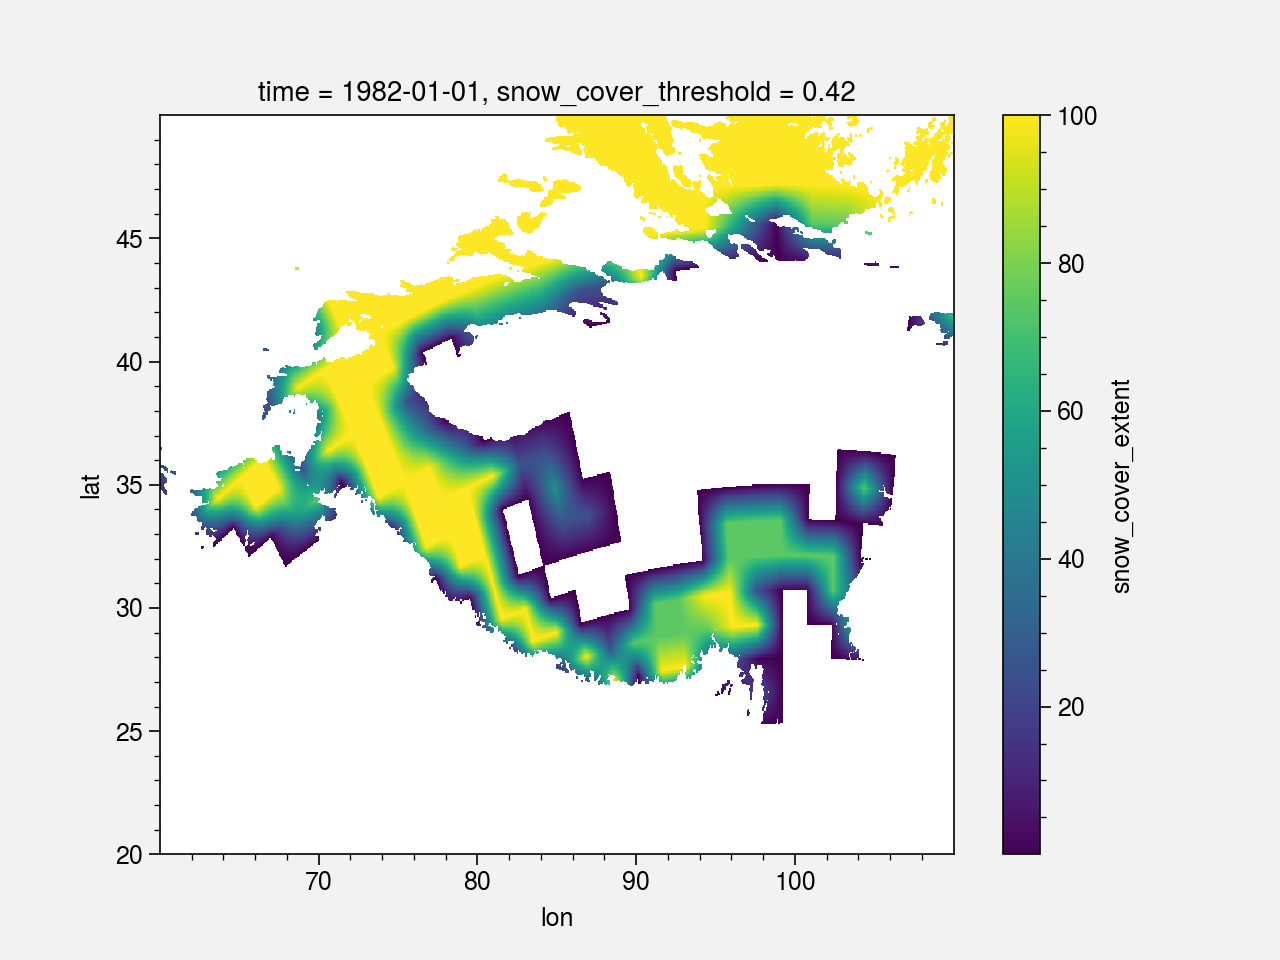

In [29]:
test.where((topo_regrid > 1500) & (test > 0)).plot()

In [32]:
test.where((topo_regrid > 1500) & (test > 0)).count()

<xarray.DataArray 'snow_cover_extent' ()>
array(143668)
Coordinates:
    time                  datetime64[ns] 1982-01-01
    snow_cover_threshold  float32 0.42